## Import Libraries

We import the required libraries. Note that some models (XGBoost, LightGBM, CatBoost, and the DNN via TensorFlow/Keras) use GPU if availabl.


In [1]:
# !pip install scikeras --quiet

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

# Use seaborn style
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import time
start_time = time.time()

## Load Data & Handle Missing Values

We load the train, test, and sample submission files. The test set has one missing value (in `winddirection`) that we impute with the media.


In [3]:
# Load datasets and handle missing values
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", submission.shape)

# Impute the missing winddirection in test with median
if test['winddirection'].isnull().sum() > 0:
    test['winddirection'].fillna(test['winddirection'].median(), inplace=True)

# Define feature set and target
X = train.drop(columns=['id', 'rainfall'])
y = train['rainfall']
X_test = test.drop(columns=['id'])
test_ids = test['id']

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")

Train shape: (2190, 13)
Test shape: (730, 12)
Submission shape: (730, 2)

Total Execution Time: 0.05 seconds


## Define Preprocessing Pipelines

We create a dictionary of different preprocessing variants. These include no scaling ("raw"), StandardScaler, RobustScaler, MinMaxScaler, and a pipeline with PCA (after standard scaling.


In [4]:
# Define various preprocessing pipelines
preproc_pipelines = {
    'raw': None,  # No scaling, using raw features
    'standard': StandardScaler(),
    'robust': RobustScaler(),
    'minmax': MinMaxScaler(),
    'pca': Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95))])
}

## Define Models & Hyperparameter Grids

We set up a dictionary of models (including logistic regression, decision tree, random forest, extra trees, gradient boosting, XGBoost, LightGBM, CatBoost, and a Deep Neural Network) along with example hyperparameter grids for tuning. GPU settings are applied where possibl.


In [5]:
# Define model dictionary and hyperparameter grids

# Logistic Regression (with L2 & L1)
models = {}
param_grids = {}

# Logistic Regression variants (using logistic regression for binary classification)
models['logistic'] = LogisticRegression(solver='liblinear', max_iter=1000)
param_grids['logistic'] = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Decision Tree
models['dt'] = DecisionTreeClassifier(random_state=42)
param_grids['dt'] = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Random Forest
models['rf'] = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grids['rf'] = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# Extra Trees
models['et'] = ExtraTreesClassifier(random_state=42, n_jobs=-1)
param_grids['et'] = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# Gradient Boosting (sklearn)
models['gb'] = GradientBoostingClassifier(random_state=42)
param_grids['gb'] = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# XGBoost (using GPU - tree_method='gpu_hist' if available)
models['xgb'] = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grids['xgb'] = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# LightGBM (with GPU support)
models['lgb'] = lgb.LGBMClassifier(device='gpu', random_state=42)
param_grids['lgb'] = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

# CatBoost (with GPU support; silent mode to reduce output)
# models['cat'] = CatBoostClassifier(task_type='GPU', verbose=0, random_state=42)
param_grids['cat'] = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5, 7]
}

# Deep Neural Network (Keras)
def create_dnn_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])
    return model

# models['dnn'] = KerasClassifier(build_fn=create_dnn_model, verbose=0)
param_grids['dnn'] = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3],
    'epochs': [20],
    'batch_size': [32, 64]
}

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")


Total Execution Time: 0.10 seconds


## Model Training, Hyperparameter Tuning & Submission Generation

We loop over each preprocessing pipeline and each model. For each combination, we transform the data (if applicable), run a randomized search with 5-fold CV (scoring by ROC AUC), record the best score and estimator, generate test predictions, and save a submission file. Results are stored in a results dictionar.


In [6]:
# Train models over different preprocessing pipelines and generate submissions

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a directory to store submissions
os.makedirs("submissions", exist_ok=True)

for prep_name, scaler in preproc_pipelines.items():
    # Preprocess training data
    if scaler is not None:
        X_train_trans = scaler.fit_transform(X)
        X_test_trans = scaler.transform(X_test)
    else:
        X_train_trans = X.values  # raw
        X_test_trans = X_test.values
        
    for model_name, model in models.items():
        print(f"Processing: Preprocessor = {prep_name}, Model = {model_name}")
        param_grid = param_grids[model_name]
        
        # Create pipeline (if needed, we can combine scaler and model but here we already preprocessed)
        # Use RandomizedSearchCV for hyperparameter tuning
        search = RandomizedSearchCV(model, param_grid, n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
        start = time.time()
        search.fit(X_train_trans, y)
        elapsed = time.time() - start
        best_score = search.best_score_
        best_estimator = search.best_estimator_
        
        print(f"Best CV ROC AUC: {best_score:.4f} in {elapsed:.1f} sec")
        
        # Generate test predictions (probability for class 1)
        test_preds = best_estimator.predict_proba(X_test_trans)[:,1]
        sub_df = pd.DataFrame({'id': test_ids, 'rainfall': test_preds})
        sub_filename = f"submissions/{prep_name}_{model_name}_submission.csv"
        sub_df.to_csv(sub_filename, index=False)
        print(f"Submission file saved: {sub_filename}\n")
        
        # Store results for later comparison
        results.append({
            'preproc': prep_name,
            'model': model_name,
            'cv_auc': best_score,
            'estimator': best_estimator,
            'submission_file': sub_filename
        })

        end_time = time.time()
        print(f"Total Execution Time: {end_time - start_time:.2f} seconds\n")

Processing: Preprocessor = raw, Model = logistic
Best CV ROC AUC: 0.8945 in 2.1 sec
Submission file saved: submissions/raw_logistic_submission.csv

Total Execution Time: 2.20 seconds

Processing: Preprocessor = raw, Model = dt
Best CV ROC AUC: 0.8405 in 0.2 sec
Submission file saved: submissions/raw_dt_submission.csv

Total Execution Time: 2.37 seconds

Processing: Preprocessor = raw, Model = rf
Best CV ROC AUC: 0.8892 in 5.6 sec
Submission file saved: submissions/raw_rf_submission.csv

Total Execution Time: 8.00 seconds

Processing: Preprocessor = raw, Model = et
Best CV ROC AUC: 0.8921 in 3.1 sec
Submission file saved: submissions/raw_et_submission.csv

Total Execution Time: 11.13 seconds

Processing: Preprocessor = raw, Model = gb
Best CV ROC AUC: 0.8829 in 11.1 sec
Submission file saved: submissions/raw_gb_submission.csv

Total Execution Time: 22.22 seconds

Processing: Preprocessor = raw, Model = xgb
Best CV ROC AUC: 0.8913 in 15.0 sec
Submission file saved: submissions/raw_xgb_su

## Compare Top 3 Results & Feature Importance

We now sort the results by CV ROC AUC and select the top three. For models that expose feature importance (e.g., tree-based models or logistic regression), we display the top 10 features. (For the DNN, feature importance isn’t directly available)


In [7]:
# Compare results and extract feature importance for top 3 models
results_df = pd.DataFrame(results).sort_values(by='cv_auc', ascending=False)
print("Top 3 Models:")
print(results_df[['preproc', 'model', 'cv_auc', 'submission_file']].head(3))

top3 = results_df.head(3)

for idx, row in top3.iterrows():
    est = row['estimator']
    model_name = row['model']
    prep = row['preproc']
    print(f"\nFeature importance for {prep}_{model_name}:")
    
    # For tree-based and linear models we try to extract feature importance/coefficients
    if hasattr(est, 'feature_importances_'):
        importances = est.feature_importances_
        feature_names = X.columns
        imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
        print(imp_df.head(10))
    elif hasattr(est, 'coef_'):
        coefs = est.coef_.flatten()
        feature_names = X.columns
        coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs}).sort_values(by='coefficient', key=abs, ascending=False)
        print(coef_df.head(10))
    else:
        print("Feature importance not available for this model.")

    end_time = time.time()
    print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds\n")

Top 3 Models:
     preproc     model    cv_auc                               submission_file
14    robust  logistic  0.894837    submissions/robust_logistic_submission.csv
21    minmax  logistic  0.894602    submissions/minmax_logistic_submission.csv
7   standard  logistic  0.894579  submissions/standard_logistic_submission.csv

Feature importance for robust_logistic:
        feature  coefficient
7         cloud     1.205549
5      dewpoint     1.060933
8      sunshine    -0.948392
6      humidity     0.461394
4       mintemp    -0.448935
1      pressure    -0.336537
3   temparature    -0.257602
10    windspeed     0.199970
2       maxtemp     0.102000
0           day     0.100876

Total Execution Time: 235.96 seconds


Feature importance for minmax_logistic:
        feature  coefficient
7         cloud     5.963563
5      dewpoint     3.473230
6      humidity     2.276808
8      sunshine    -2.009344
1      pressure    -1.555698
4       mintemp    -1.354930
3   temparature    -0.75294

## Summary & Next Steps

We have compared several preprocessing techniques and models. Each combination produced a submission file and CV ROC AUC score. The top models (by ROC AUC) are listed above with their feature importances. Next steps include refining the hyperparameter search, ensembling top performers, and further feature engineering (such as creating seasonal features from the 'day' column).

### Conclusion

This notebook explored multiple preprocessing techniques and models (from logistic regression to deep neural networks) for the Rainfall Prediction task. We:
- Experimented with five preprocessing pipelines.
- Ran hyperparameter tuning using RandomizedSearchCV with 5-fold CV.
- Trained a variety of models including tree-based methods, boosting (XGB, LGB, CatBoost), and a DNN.
- Generated submission files for each combination.
- Compared model performance using ROC AUC and extracted feature importances for the top 3 models.

Feel free to build on this “super code” by refining hyperparameters, ensembling models, or adding additional feature engineering steps. Happy modeling and good luck in the cometition!


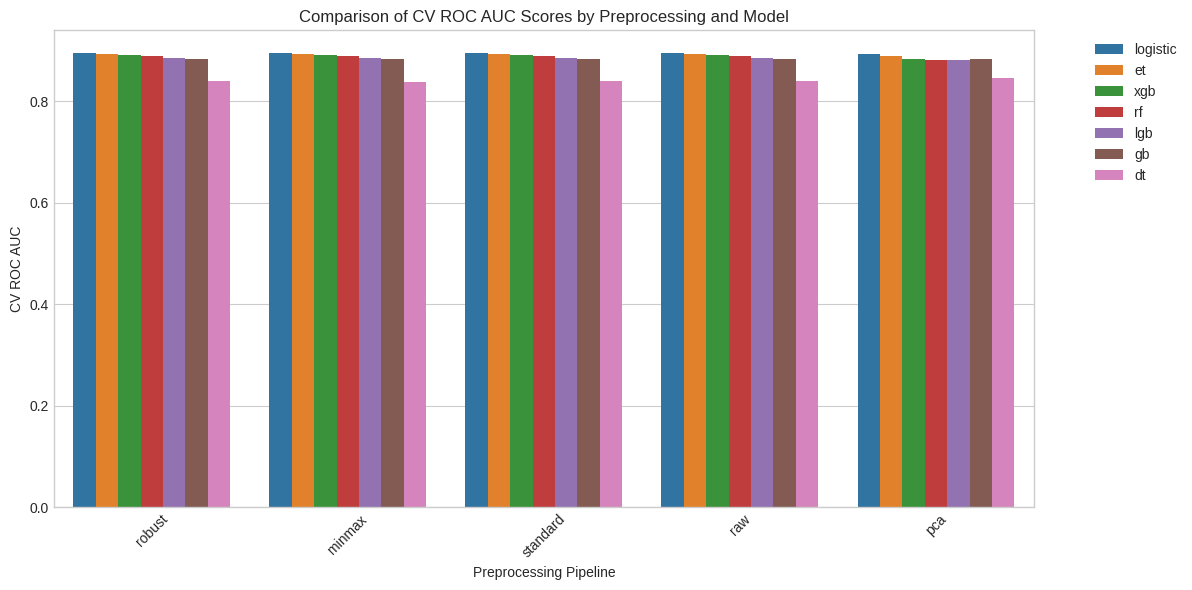

In [8]:
plt.figure(figsize=(12, 6))
# Create a barplot with preprocessing pipelines on the x-axis, and AUC scores as the height; hue = model
sns.barplot(x='preproc', y='cv_auc', hue='model', data=results_df)
plt.title("Comparison of CV ROC AUC Scores by Preprocessing and Model")
plt.xlabel("Preprocessing Pipeline")
plt.ylabel("CV ROC AUC")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Create Weighted Ensemble Submission

In this cell, we load the submission files for the three logistic regression models with different preprocessors (robust, minmax, standard). Their CV ROC AUC scores are given as:  
- **robust_logistic**: 0.86055  
- **minmax_logistic**: 0.86028  
- **standard_logistic**: 0.85974  

We compute normalized weights based on these scores and form a weighted average of their predictions. Finally, we save the ensembled predictions to `submission.csv`.

In [9]:
# Load the individual submission files
robust_sub = pd.read_csv("submissions/robust_logistic_submission.csv")
minmax_sub = pd.read_csv("submissions/minmax_logistic_submission.csv")
standard_sub = pd.read_csv("submissions/standard_logistic_submission.csv")

# Given CV ROC AUC scores for the three submissions
score_robust = 0.86055
score_minmax = 0.86028
score_standard = 0.85974

# Compute normalized weights (higher score gets slightly higher weight)
total_score = score_robust + score_minmax + score_standard
w_robust = score_robust / total_score
w_minmax = score_minmax / total_score
w_standard = score_standard / total_score

print("Weights:")
print(f"Robust: {w_robust:.4f}, MinMax: {w_minmax:.4f}, Standard: {w_standard:.4f}")

# Compute weighted ensemble predictions
ensemble_pred = (w_robust * robust_sub['rainfall'] +
                 w_minmax * minmax_sub['rainfall'] +
                 w_standard * standard_sub['rainfall'])

# Create final submission DataFrame (assuming the id columns match)
ensemble_sub = pd.DataFrame({'id': robust_sub['id'], 'rainfall': ensemble_pred})

# Save the weighted ensemble submission as 'submission.csv'
ensemble_sub.to_csv("submission.csv", index=False)
print("Weighted ensemble submission saved as submission.csv")

Weights:
Robust: 0.3335, MinMax: 0.3334, Standard: 0.3332
Weighted ensemble submission saved as submission.csv
